# Frozen Lake with OpenAI GYM



## Reinforcement Learning
Reinforcement Learning briefly is a paradigm of Learning Process in which a learning agent learns, overtime, to behave optimally in a certain environment by interacting continuously in the environment. The agent during its course of learning experience various different situations in the environment it is in. These are called states. The agent while being in that state may choose from a set of allowable actions which may fetch different rewards(or penalties). The learning agent overtime learns to maximize these rewards so as to behave optimally at any given state it is in.

## GYM

Gym is released by Open AI in 2016 (http://gym.openai.com/docs/). It is a toolkit for developing and comparing reinforcement learning algorithms. OpenAI’s mission is to ensure that artificial general intelligence benefits all of humanity. 

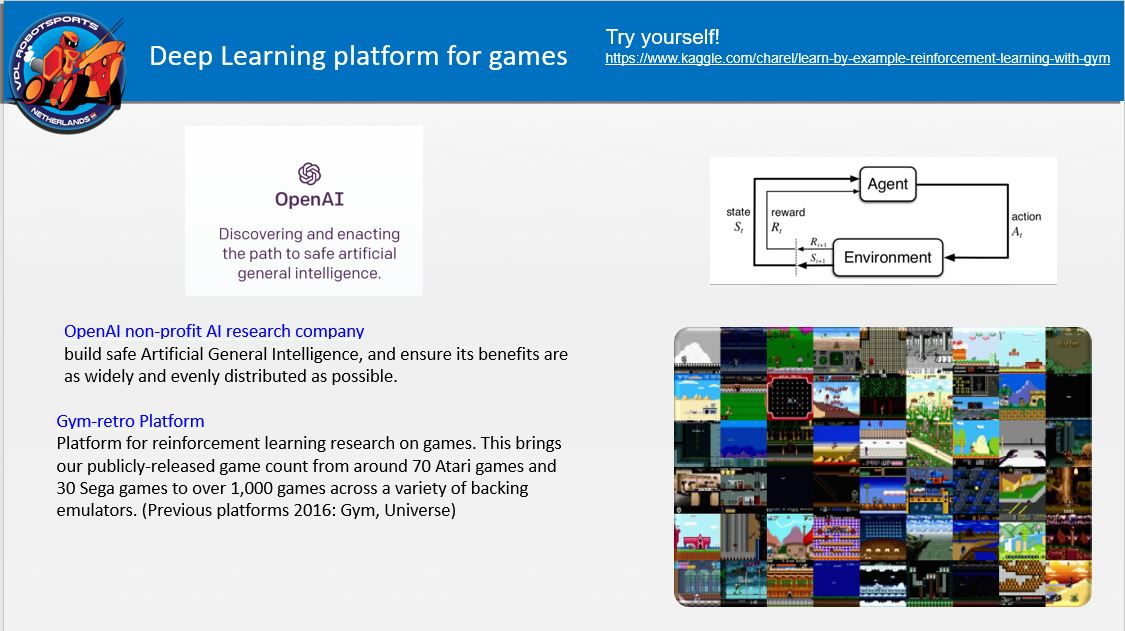

Source: OpenAI

In 2018 Gym-retro was released as its successor: https://blog.openai.com/gym-retro/

# Interacting with the Gym environment  
Source: [OpenAI](https://openai.com/)  
OPenAI/gym makes it relative straightforward to interact with the game.  
<img src="https://cdn-images-1.medium.com/max/800/1*7Ae4mf9gVvpuMgenwtf8wA.png">

Each timestep, the agent chooses an action, and the environment returns an observation and a reward.  

*observation, reward, done, info = env.step(action) *  
* observation (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game line Taxi.
* reward (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
* done (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
* info (dict): ignore, diagnostic information useful for debugging. Official evaluations of your agent are not allowed to use this for learning.  

Let's first do some random steps in the game so you see how the game looks like

## FrozenLake Problem

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.
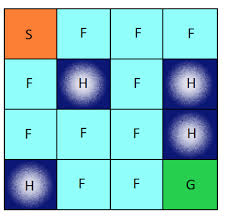


* S=Start
* F=Frozen
* H=Hole
* G=Goal

In [1]:
import gym

In [2]:
import torch
import time
import matplotlib.pyplot as plt

In [3]:

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)

env = gym.make('FrozenLakeNotSlippery-v0')

# Instantiate the Environment.
# env = gym.make('FrozenLake-v0')

# To check all environments present in OpenAI
# print(envs.registry.all())


env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
# Total number of States and Actions
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n
print( "States = ", number_of_states)
print( "Actions = ", number_of_actions)

num_episodes = 1000
steps_total = []
rewards_total = []
egreedy_total = []


States =  16
Actions =  4



4x4=16 States 

Left, Right, Up, Down 4 actions.

## Q-Learning Equation
#### Q-Learning is a basic form of Reinforcement Learning which uses Q-values (also called action values) to iteratively improve the behavior of the learning agent.
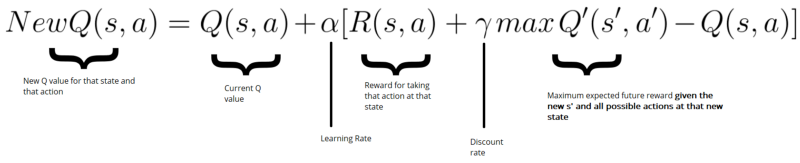


#### New Q(s,a) = (1 - learning_rate) x Q(s,a)  +  learning_rate x [ reward + discount_rate x maxQ(s',a')]  






- s : Current State of the agent.
- a : Current Action Picked according to some policy.
- s' : Next State where the agent ends up.
- a' : Next best action to be picked using current Q-value estimation, i.e. pick the action with the maximum Q-value in the next state.
- R : Current Reward observed from the environment in Response of current action.
- 𝛾 (>0 and <=1) : Discounting Factor for Future Rewards. Future rewars are less valuable than current rewards so they must be discounted. Since Q-value is an estimation of expected rewards from a state, discounting rule applies here as well.
- 𝛼  : Step length taken to update the estimation of Q(S, A).

###  Learning Rate ($\alpha$)

In [5]:
# if learning_rate == 0:
#      Pick value of new Q(s,a) based on past experience
# elif learning_rate == 1:
#      Pick value of new Q(s,a) based on current situtation

# Value of learning_rate(alpha) varies from [0 - 1]

### Discount Rate ($\gamma$)

In [6]:
# Discount rate accounts for the Reward the agent receive on an action

# if discount_rate == 0:
#     only current reward accounted
# elif discount_rate == 1:
#     future rewards also accounted
    

In [7]:
# PARAMS 

# Discount on reward
gamma = 0.95

# Factor to balance the ratio of action taken based on past experience to current situtation
learning_rate = 0.9



## Exploration vs Exploitation
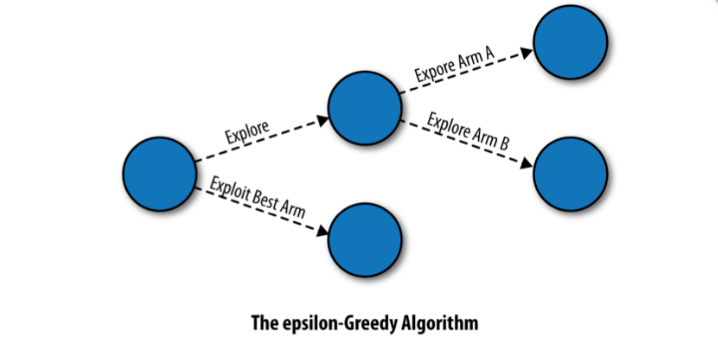

- Choosing the Action to take using  𝜖 -greedy policy:
- 𝜖 -greedy policy of is a very simple policy of choosing actions using the current Q-value estimations. It goes as follows :
- With probability (1- $\epsilon$ ) choose the action which has the highest Q-value.
- With probability ($\epsilon$) choose any action at random.





In [8]:
# exploit vs explore to find action
# Start with 70% random actions to explore the environment
# And with time, using decay to shift to more optimal actions learned from experience

egreedy = 0.7
egreedy_final = 0.1
egreedy_decay = 0.999

In [9]:
Q = torch.zeros([number_of_states, number_of_actions])
Q


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [10]:
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        random_for_egreedy = torch.rand(1)[0]
        

        if random_for_egreedy > egreedy:      
            random_values = Q[state] + torch.rand(1,number_of_actions) / 1000      
            action = torch.max(random_values,1)[1][0]  
            action = action.item()
        else:
            action = env.action_space.sample()
            
        if egreedy > egreedy_final:
            egreedy *= egreedy_decay
        
        new_state, reward, done, info = env.step(action)

        # Filling the Q Table
        Q[state, action] = reward + gamma * torch.max(Q[new_state])
        
        # Setting new state for next action
        state = new_state
        
        # env.render()
        # time.sleep(0.4)
        
        if done:
            steps_total.append(step)
            rewards_total.append(reward)
            egreedy_total.append(egreedy)
            if i_episode % 10 == 0:
                print('Episode: {} Reward: {} Steps Taken: {}'.format(i_episode,reward, step))
            break
        



Episode: 0 Reward: 0.0 Steps Taken: 9
Episode: 10 Reward: 0.0 Steps Taken: 15
Episode: 20 Reward: 0.0 Steps Taken: 5
Episode: 30 Reward: 0.0 Steps Taken: 12
Episode: 40 Reward: 0.0 Steps Taken: 8
Episode: 50 Reward: 0.0 Steps Taken: 5
Episode: 60 Reward: 0.0 Steps Taken: 7
Episode: 70 Reward: 0.0 Steps Taken: 7
Episode: 80 Reward: 0.0 Steps Taken: 29
Episode: 90 Reward: 0.0 Steps Taken: 3
Episode: 100 Reward: 0.0 Steps Taken: 8
Episode: 110 Reward: 0.0 Steps Taken: 11
Episode: 120 Reward: 0.0 Steps Taken: 11
Episode: 130 Reward: 0.0 Steps Taken: 2
Episode: 140 Reward: 0.0 Steps Taken: 6
Episode: 150 Reward: 0.0 Steps Taken: 16
Episode: 160 Reward: 0.0 Steps Taken: 7
Episode: 170 Reward: 0.0 Steps Taken: 2
Episode: 180 Reward: 0.0 Steps Taken: 13
Episode: 190 Reward: 0.0 Steps Taken: 26
Episode: 200 Reward: 0.0 Steps Taken: 4
Episode: 210 Reward: 0.0 Steps Taken: 10
Episode: 220 Reward: 0.0 Steps Taken: 15
Episode: 230 Reward: 0.0 Steps Taken: 3
Episode: 240 Reward: 0.0 Steps Taken: 22


In [11]:
print(Q)
        
print("Percent of episodes finished successfully: {0}".format(sum(rewards_total)/num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0}".format(sum(rewards_total[-100:])/100))

print("Average number of steps: %.2f" % (sum(steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))


tensor([[0.7351, 0.6983, 0.7738, 0.7351],
        [0.7351, 0.0000, 0.8145, 0.7738],
        [0.7738, 0.8574, 0.7738, 0.8145],
        [0.8145, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7351],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9025, 0.0000, 0.8145],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8574, 0.0000],
        [0.8145, 0.0000, 0.9025, 0.0000],
        [0.8574, 0.9500, 0.0000, 0.8574],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9025, 0.9500, 0.0000],
        [0.9025, 0.9500, 1.0000, 0.9025],
        [0.0000, 0.0000, 0.0000, 0.0000]])
Percent of episodes finished successfully: 0.635
Percent of episodes finished successfully (last 100 episodes): 0.89
Average number of steps: 6.72
Average number of steps (last 100 episodes): 6.58


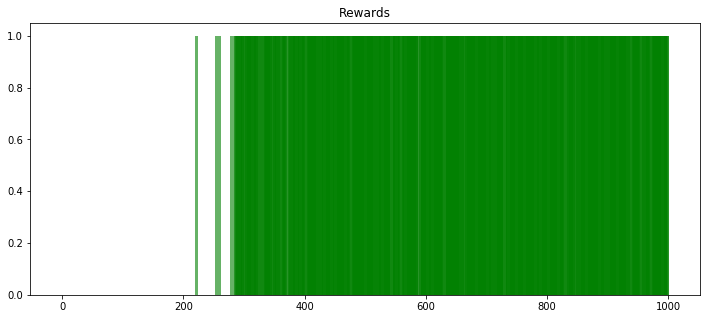

In [12]:
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total, alpha=0.6, color='green', width=5)
plt.show()



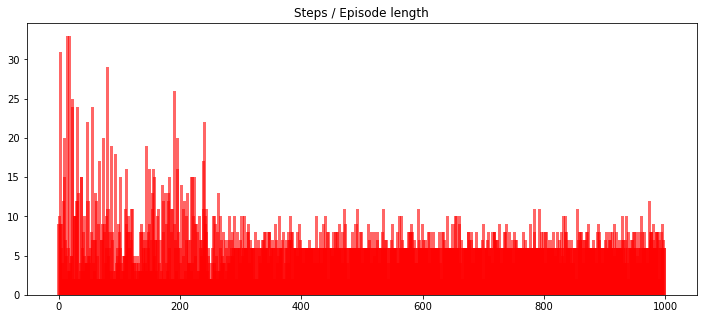

In [13]:
plt.figure(figsize=(12,5))
plt.title("Steps / Episode length")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='red', width=5)
plt.show()



#### Here, we can see that the steps taken in an episode is large because we have high random action in the starting and later on...as we learn from experience, we start to take more informed steps , hence less noise 

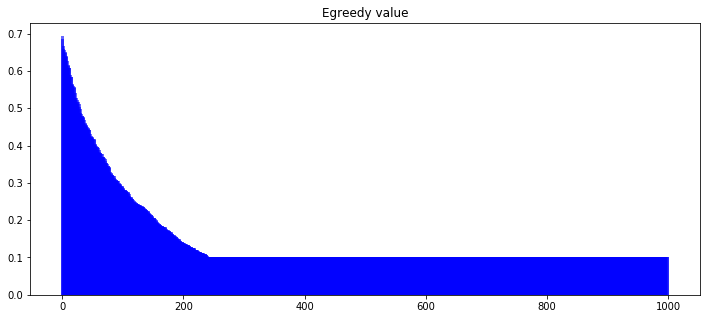

In [14]:
plt.figure(figsize=(12,5))
plt.title("Egreedy value")
plt.bar(torch.arange(len(egreedy_total)), egreedy_total, alpha=0.6, color='blue', width=5)
plt.show()


 #### In the above graph, we can see how  egreedy ($\epsilon$) value is reducing with time 

- Hoped you liked my notebook (upvote top right), my way to conribute back to this fantastic Kaggle platform and community.
- Author - Arjit Sharma